# Part 1: Time series and other simple plots

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) ## suppress annoying deprecation warnings

from datetime import datetime

import pandas as pd
import seaborn.objects as so
from matplotlib import style

import plotly.express as px

In [2]:
# Renaming columns for better axis labels in plots
col_rename = {
	'tavg': 'Temp_Avg_°C',
	'tmax': 'Temp_Max_°C',
	'tmin': 'Temp_Min_°C',
	'rhum': 'Rel_Humidity_%',
	'coco': 'Condition',
	'wspd': 'Wind_Speed_kmh',
	'prcp': 'Precipation_mm',
	'wdir': 'Wind_Direction_°',
	'pres': 'Air_pressure_hPa',
	'dwpt': 'Dew_point_°C'
}

In [3]:
weather_df = pd.read_csv('global_weather.csv', parse_dates=['time'], dtype={'wmo':str, 'station':str}) 
weather_df = weather_df.dropna()

weather_df.rename(columns=col_rename, inplace=True)
weather_df = weather_df.assign(Continent = weather_df["timezone"].str.split('/').str[0])  ## Get continent from timezone column

weather_df.loc[weather_df["name"] == "Berlin / Tempelhof",:].head()  ## Let's have a look at a single city (capital)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,...,Rel_Humidity_%,Condition,Temp_Avg_°C,Temp_Min_°C,Temp_Max_°C,Precipation_mm,Wind_Direction_°,Wind_Speed_kmh,Air_pressure_hPa,Continent
1412,Berlin / Tempelhof,DE,BE,10384,EDDI,52.4667,13.4,50.0,Europe/Berlin,1929-08-01,...,80.0,Overcast,7.8,5.5,10.0,0.3,144.0,9.0,1007.8,Europe
1413,Berlin / Tempelhof,DE,BE,10384,EDDI,52.4667,13.4,50.0,Europe/Berlin,1929-08-01,...,68.0,Overcast,9.4,6.3,13.3,0.0,132.0,7.6,1007.3,Europe
1414,Berlin / Tempelhof,DE,BE,10384,EDDI,52.4667,13.4,50.0,Europe/Berlin,1929-08-01,...,64.0,Overcast,10.4,7.0,14.8,0.0,93.0,13.3,1005.8,Europe
1415,Berlin / Tempelhof,DE,BE,10384,EDDI,52.4667,13.4,50.0,Europe/Berlin,1929-08-01,...,74.0,Clear,9.4,6.1,12.8,0.0,71.0,12.6,1010.0,Europe
1416,Berlin / Tempelhof,DE,BE,10384,EDDI,52.4667,13.4,50.0,Europe/Berlin,1929-08-01,...,63.0,Clear,4.6,-0.8,8.0,0.0,66.0,14.4,1017.0,Europe


## My first seaborn.objects plot

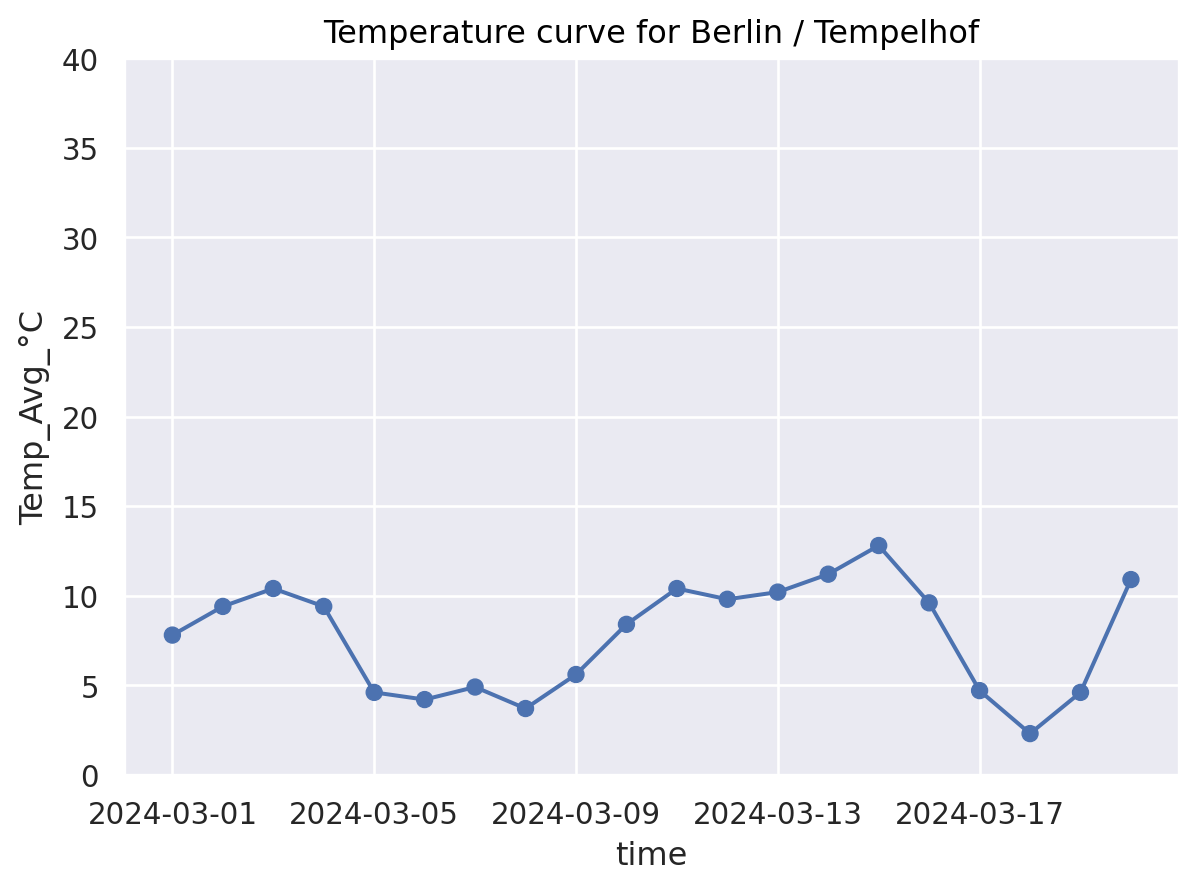

In [4]:
so.Plot.config.display["scaling"] = 1.0 ## Adjust standard output size to your liking 

(
    so.Plot(
		weather_df.loc[weather_df["name"] == "Berlin / Tempelhof",:],   ## Data layer (required)
		x="time", y="Temp_Avg_°C")                          			## Axis mapping layer (required)
    .add(so.Dot())                                                  	## Geometry layer (at least one required)
	.add(so.Line())                                                 	# Connect with lines (optional geometry layer)
	.limit(y=(0, 40))                                               	# Coordinate layer (optional: problem avoid free y-axis)
    .label(title="Temperature curve for Berlin / Tempelhof")            # Theme and label layers (optional)
)

## Plotting distributions
### How is the temperature range over all cities?

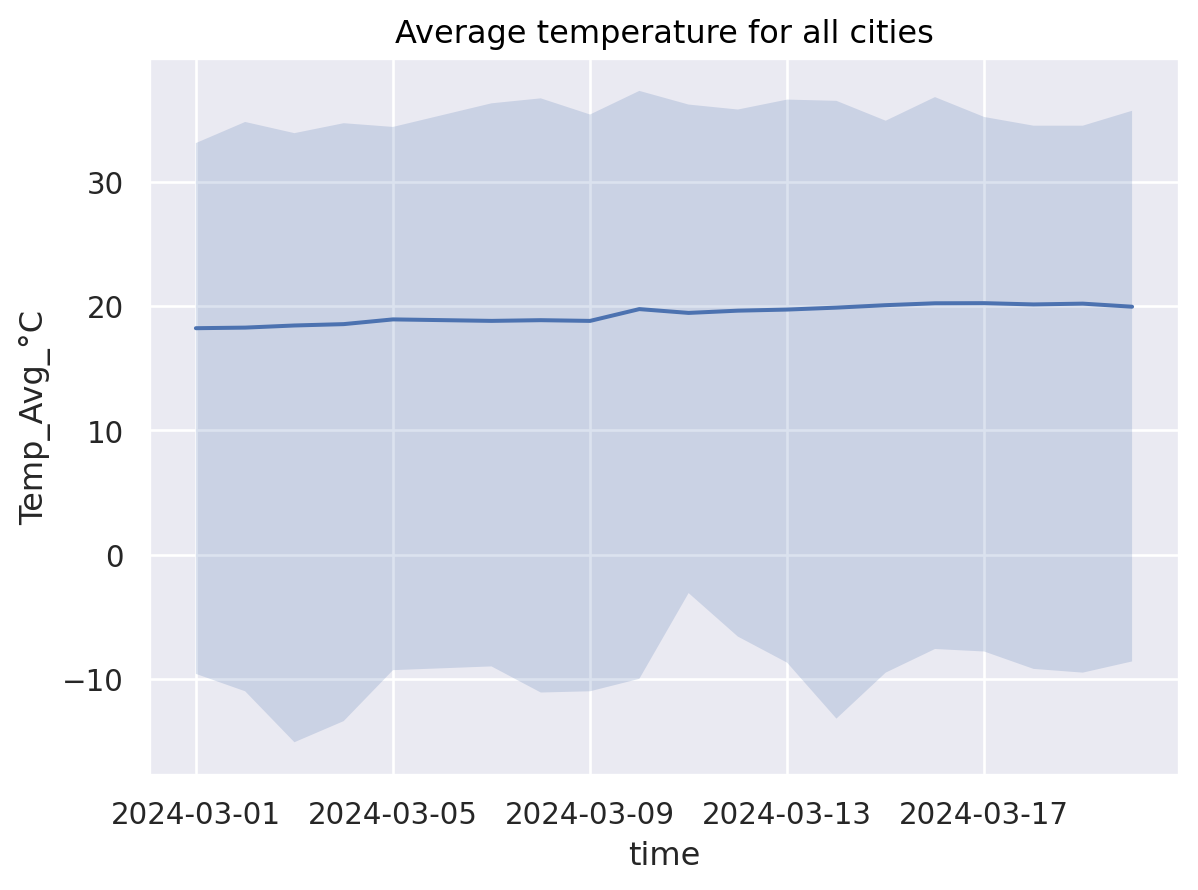

In [5]:
miss_timepoint= weather_df.time == datetime(2024, 3, 6) ## Simulate a missing timepoint and see what happens in plots
(
	so.Plot(weather_df[~miss_timepoint], x="time", y="Temp_Avg_°C")  ## Can you spot the missing time point?
    .add(so.Band()) 										# Geometry: Min-Max Band
	.add(so.Line(), 										# Geometry: Line
  	#!#    so.Agg(func=??)    								# Statistic: Mean
	   so.Agg(func='mean')    								# Statistic: Mean
	)
    .label(title="Average temperature for all cities")
)

### What are so.Band and so.Agg doing in the backgorund?

In [6]:
weather_agg = pd.concat(
	[weather_df.loc[:,["time","Temp_Avg_°C"]].groupby(["time"]).min(), 	## so.Band - min-part
	weather_df.loc[:,["time","Temp_Avg_°C"]].groupby(["time"]).mean(), 	## so.Line, so.Agg
	weather_df.loc[:,["time","Temp_Avg_°C"]].groupby(["time"]).max(),	## so.Band - max-part
	weather_df.loc[:,["time","Temp_Avg_°C"]].groupby(["time"]).count()	## Let's check how many cities are aggregated
	], 
	axis=1
)
weather_agg.columns = ["temp_min","temp_avg", "temp_max","nb_cities"]

weather_agg.head(n=10)

,temp_min,temp_avg,temp_max,nb_cities
time,,,,
2024-03-01,-9.6,18.207801,33.1,141
2024-03-02,-11.0,18.255944,34.8,143
2024-03-03,-15.1,18.426950,33.9,141
2024-03-04,-13.4,18.536170,34.7,141
2024-03-05,-9.3,18.916783,34.4,143
2024-03-06,-9.4,18.864336,35.5,143
2024-03-07,-9.0,18.797183,36.3,142
2024-03-08,-11.1,18.853901,36.7,141
2024-03-09,-11.0,18.795683,35.4,139


### Another visualization (date is categorical, show data range not as min-max but as errorbar)
Which visualization is better to see missing timepoint?

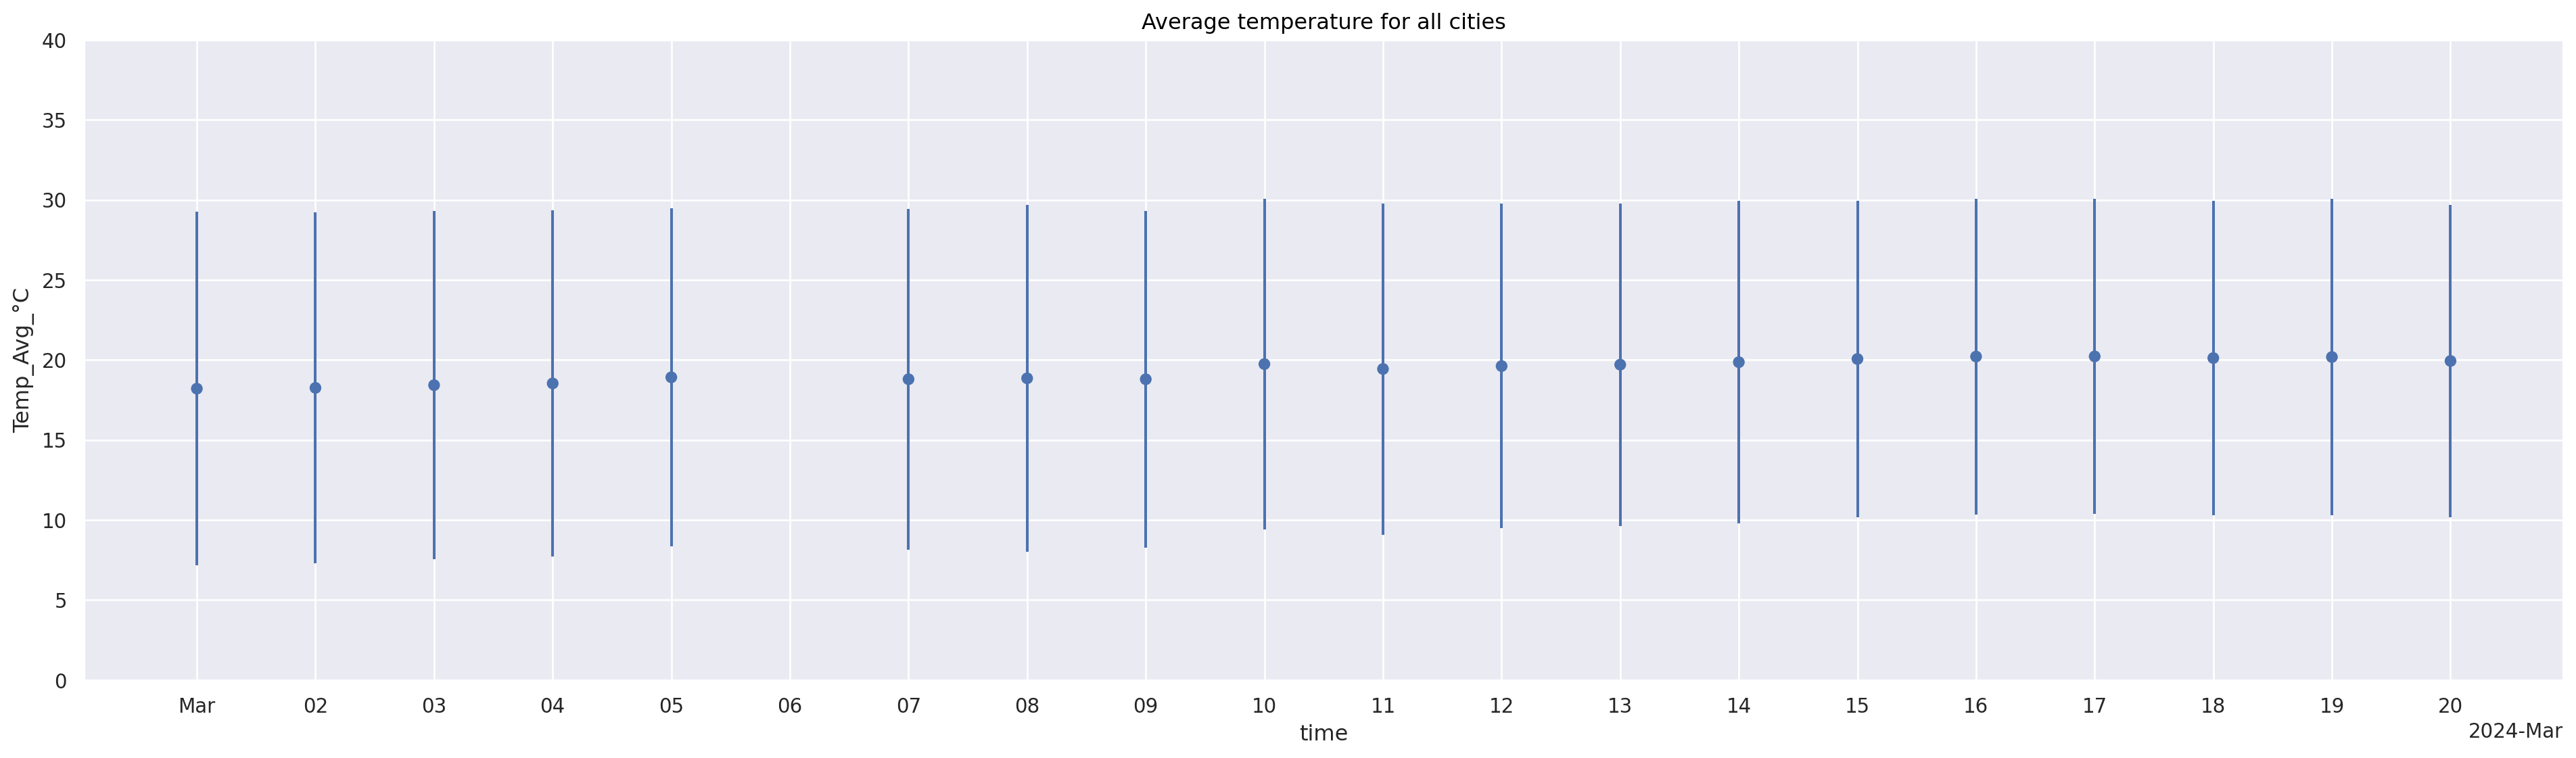

In [8]:
(
so.Plot(weather_df[~miss_timepoint], x="time", y="Temp_Avg_°C")	## Can you spot the missing time point?
	.add(so.Dot(), so.Agg()) 									# Geometry: Dot + Statistic: Mean
	#!# .add(so.???(), so.Est(errorbar=??)) 					# Geometry: Range + Statistic: Standard deviation
	.add(so.Range(), so.Est(errorbar="sd")) 					# Geometry: Range + Statistic: Standard deviation
	.limit(y=(0, 40))
	.layout(size=(20, 6)) 										# Increase the figure size for a better view
	.scale(
		x=so.Temporal().tick(upto=21).label(concise=True) 		# Increase the tick size and adjust tick labels for legibility
	)
	.label(title="Average temperature for all cities")
)

## The problem of Spaghetti Plots

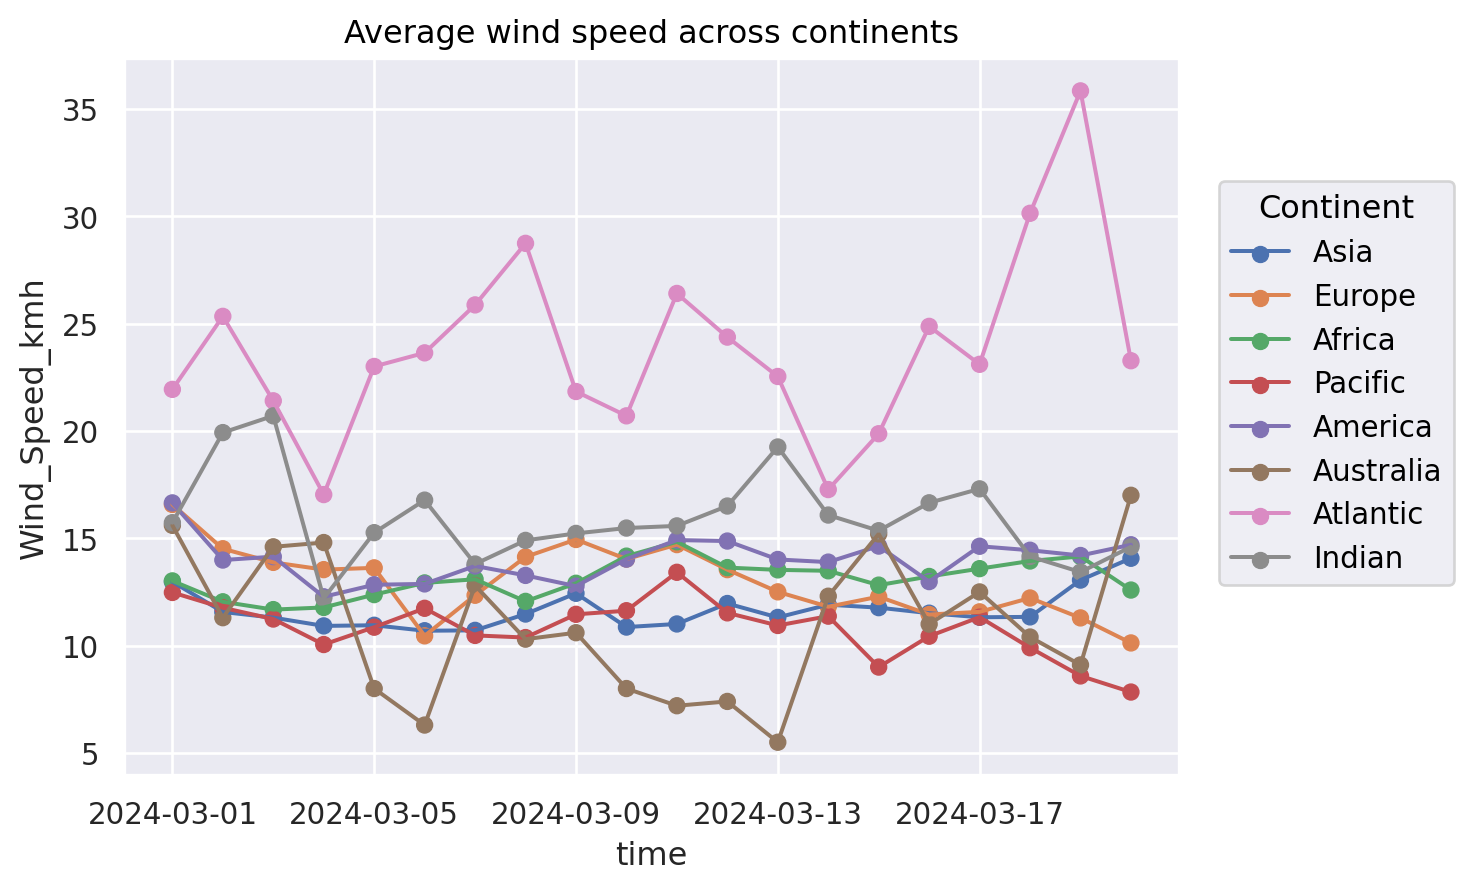

In [9]:
(
    #!# so.Plot(weather_df, x="time", y=??, color=??)
    so.Plot(weather_df, x="time", y="Wind_Speed_kmh", color="Continent")
		.add(so.Dot(), so.Agg())
		.add(so.Line(), so.Agg())
		.label(title="Average wind speed across continents")
)

### Alternatives: (1) Highlighting

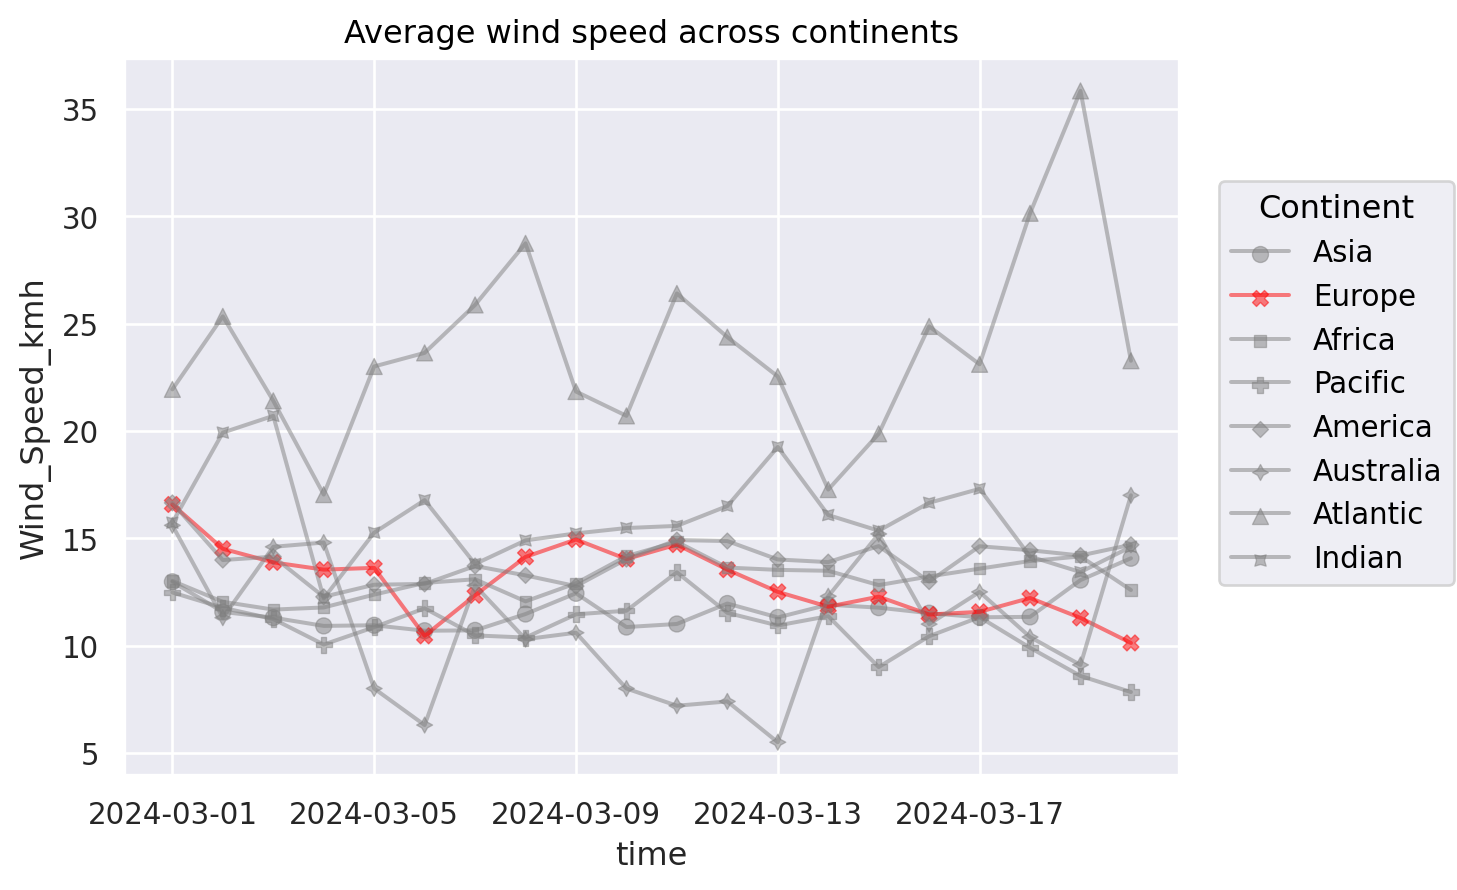

In [10]:
(
    so.Plot(weather_df, x="time", y="Wind_Speed_kmh", color="Continent")
		#!# .add(so.Dot(alpha=0.5), so.Agg(), marker=??)		# set transparency by alpha 
		.add(so.Dot(alpha=0.5), so.Agg(), marker="Continent")		# set transparency by alpha 
		.add(so.Line(alpha=0.5), so.Agg() )
		.scale(color=(							# Control the color scale
			"gray",								# Asia
		#!#	???,								# Highlight Europe
			"red",								# Highlight Europe
			"gray",								# Africa
			"gray",								# Pacific
			"gray",								# America
			"gray",								# Australia
			"gray",								# Atlantic
			"gray"								# Indian
			))
		.label(title="Average wind speed across continents")
)


### Alternatives: (2) Facet

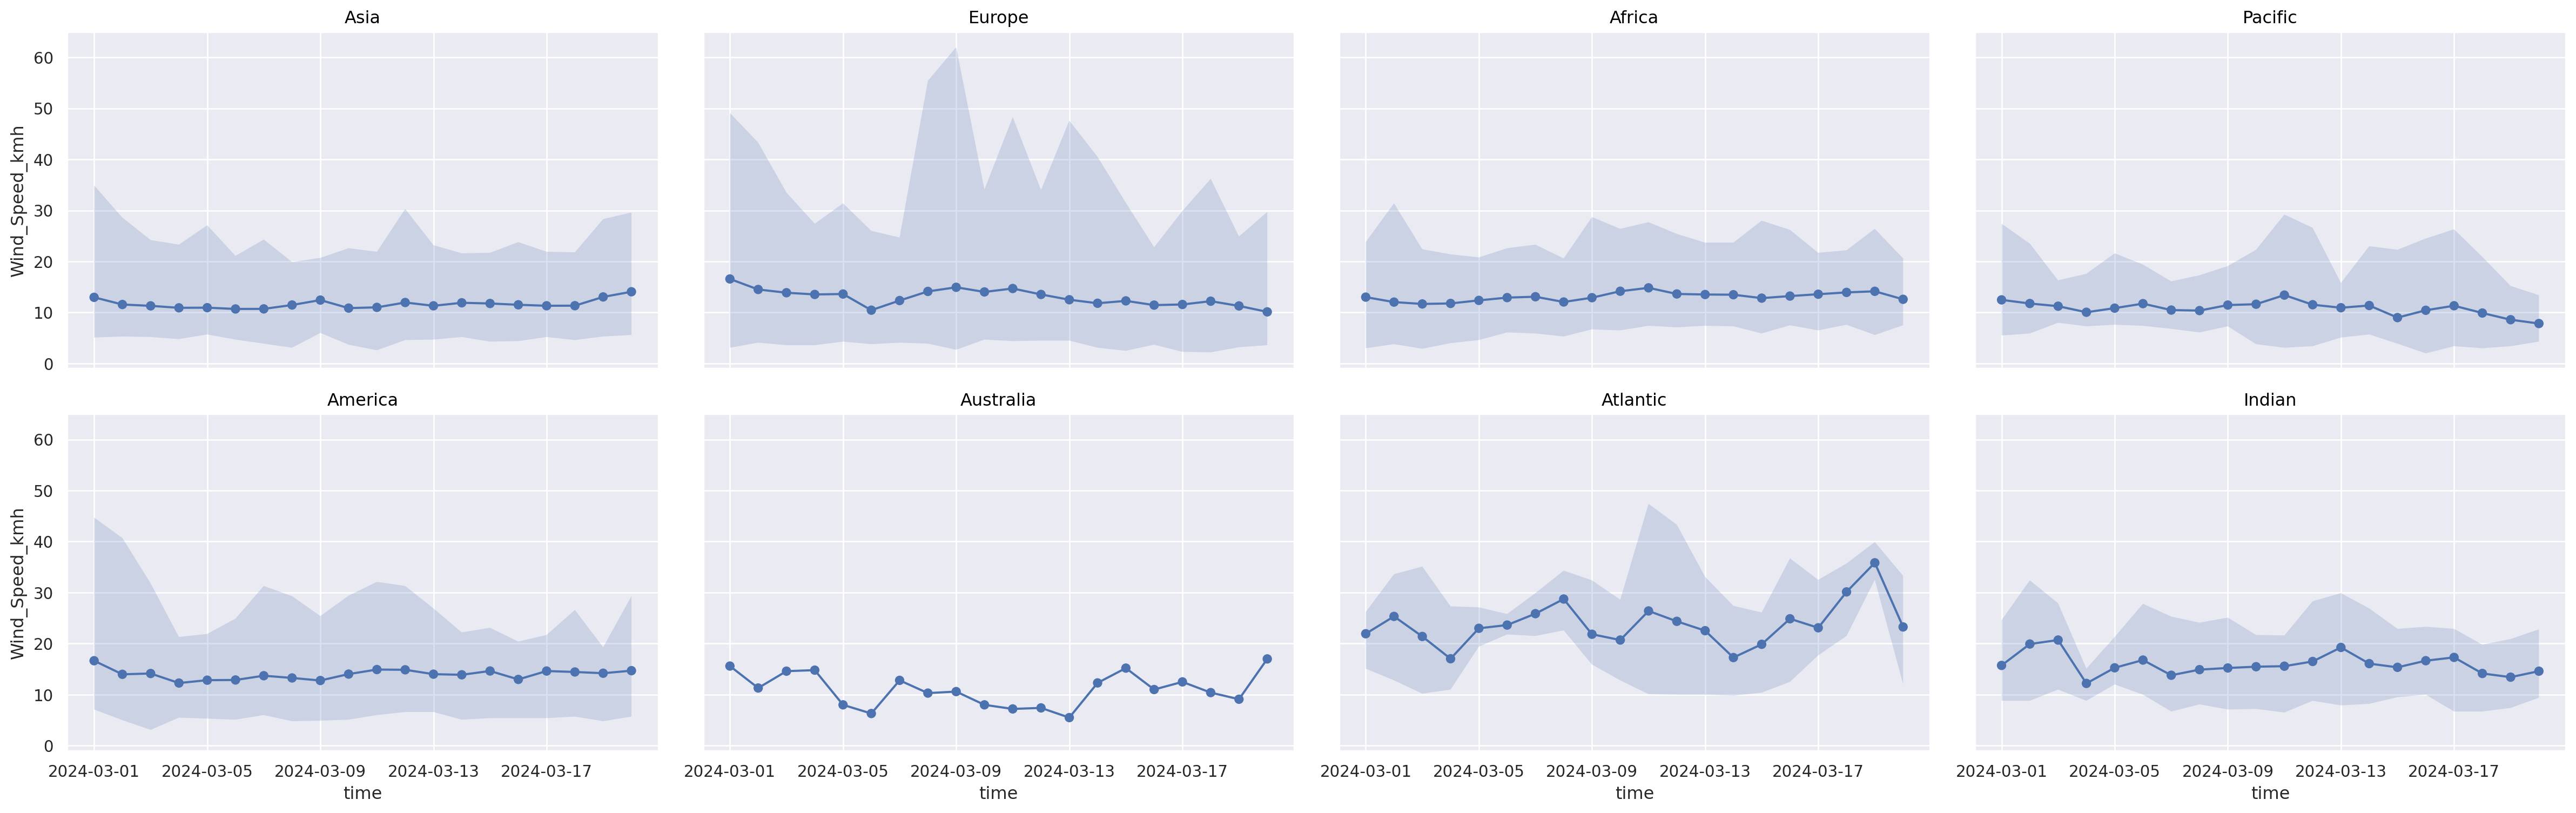

In [11]:
(
    so.Plot(weather_df, x="time", y="Wind_Speed_kmh")
		.add(so.Dot(), so.Agg())
		.add(so.Line(), so.Agg())
		.add(so.Band())
		#!# .facet(??, wrap=4)			# All you need for subplots
		.facet("Continent", wrap=4)		# All you need for subplots
		.layout(size=(25, 8))
)

## Example: relationship of temperature, date and latitude (south - north)
### How to not do it: spaghetti line plot

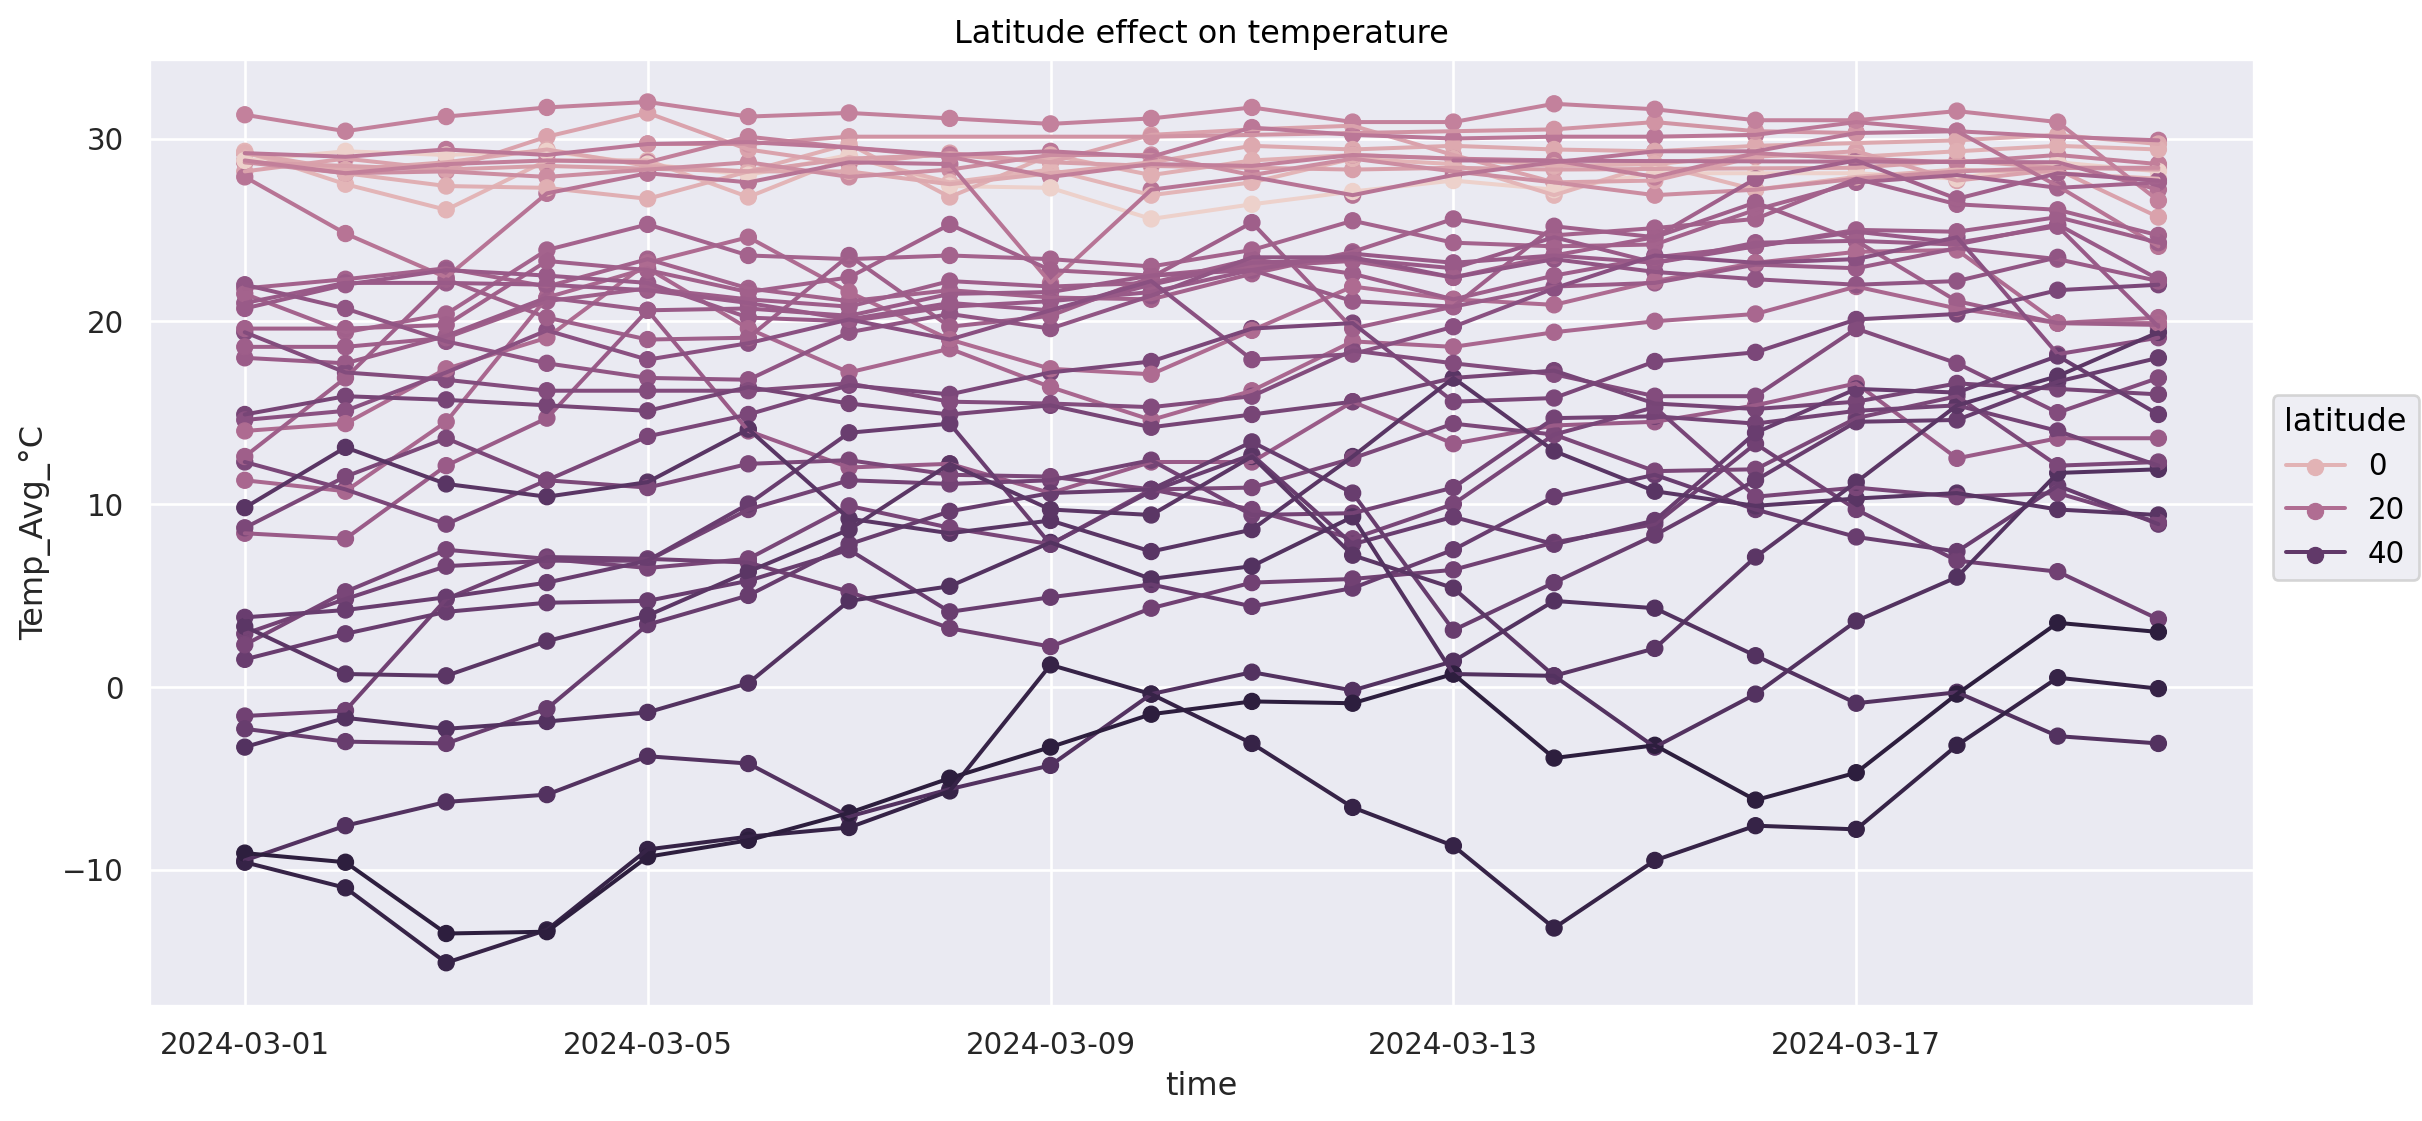

In [12]:
(
#!#	so.Plot(weather_df.loc[weather_df["Continent"] == ???], x="time", y="Temp_Avg_°C", color=??)
	so.Plot(weather_df.loc[weather_df["Continent"] == "Asia"], x="time", y="Temp_Avg_°C", color="latitude")
    .add(so.Dot())
	.add(so.Line())
    .layout(size=(12, 6))
    .label(title="Latitude effect on temperature")
)

### Alternative: Dot array and flip latitude and temperature axis

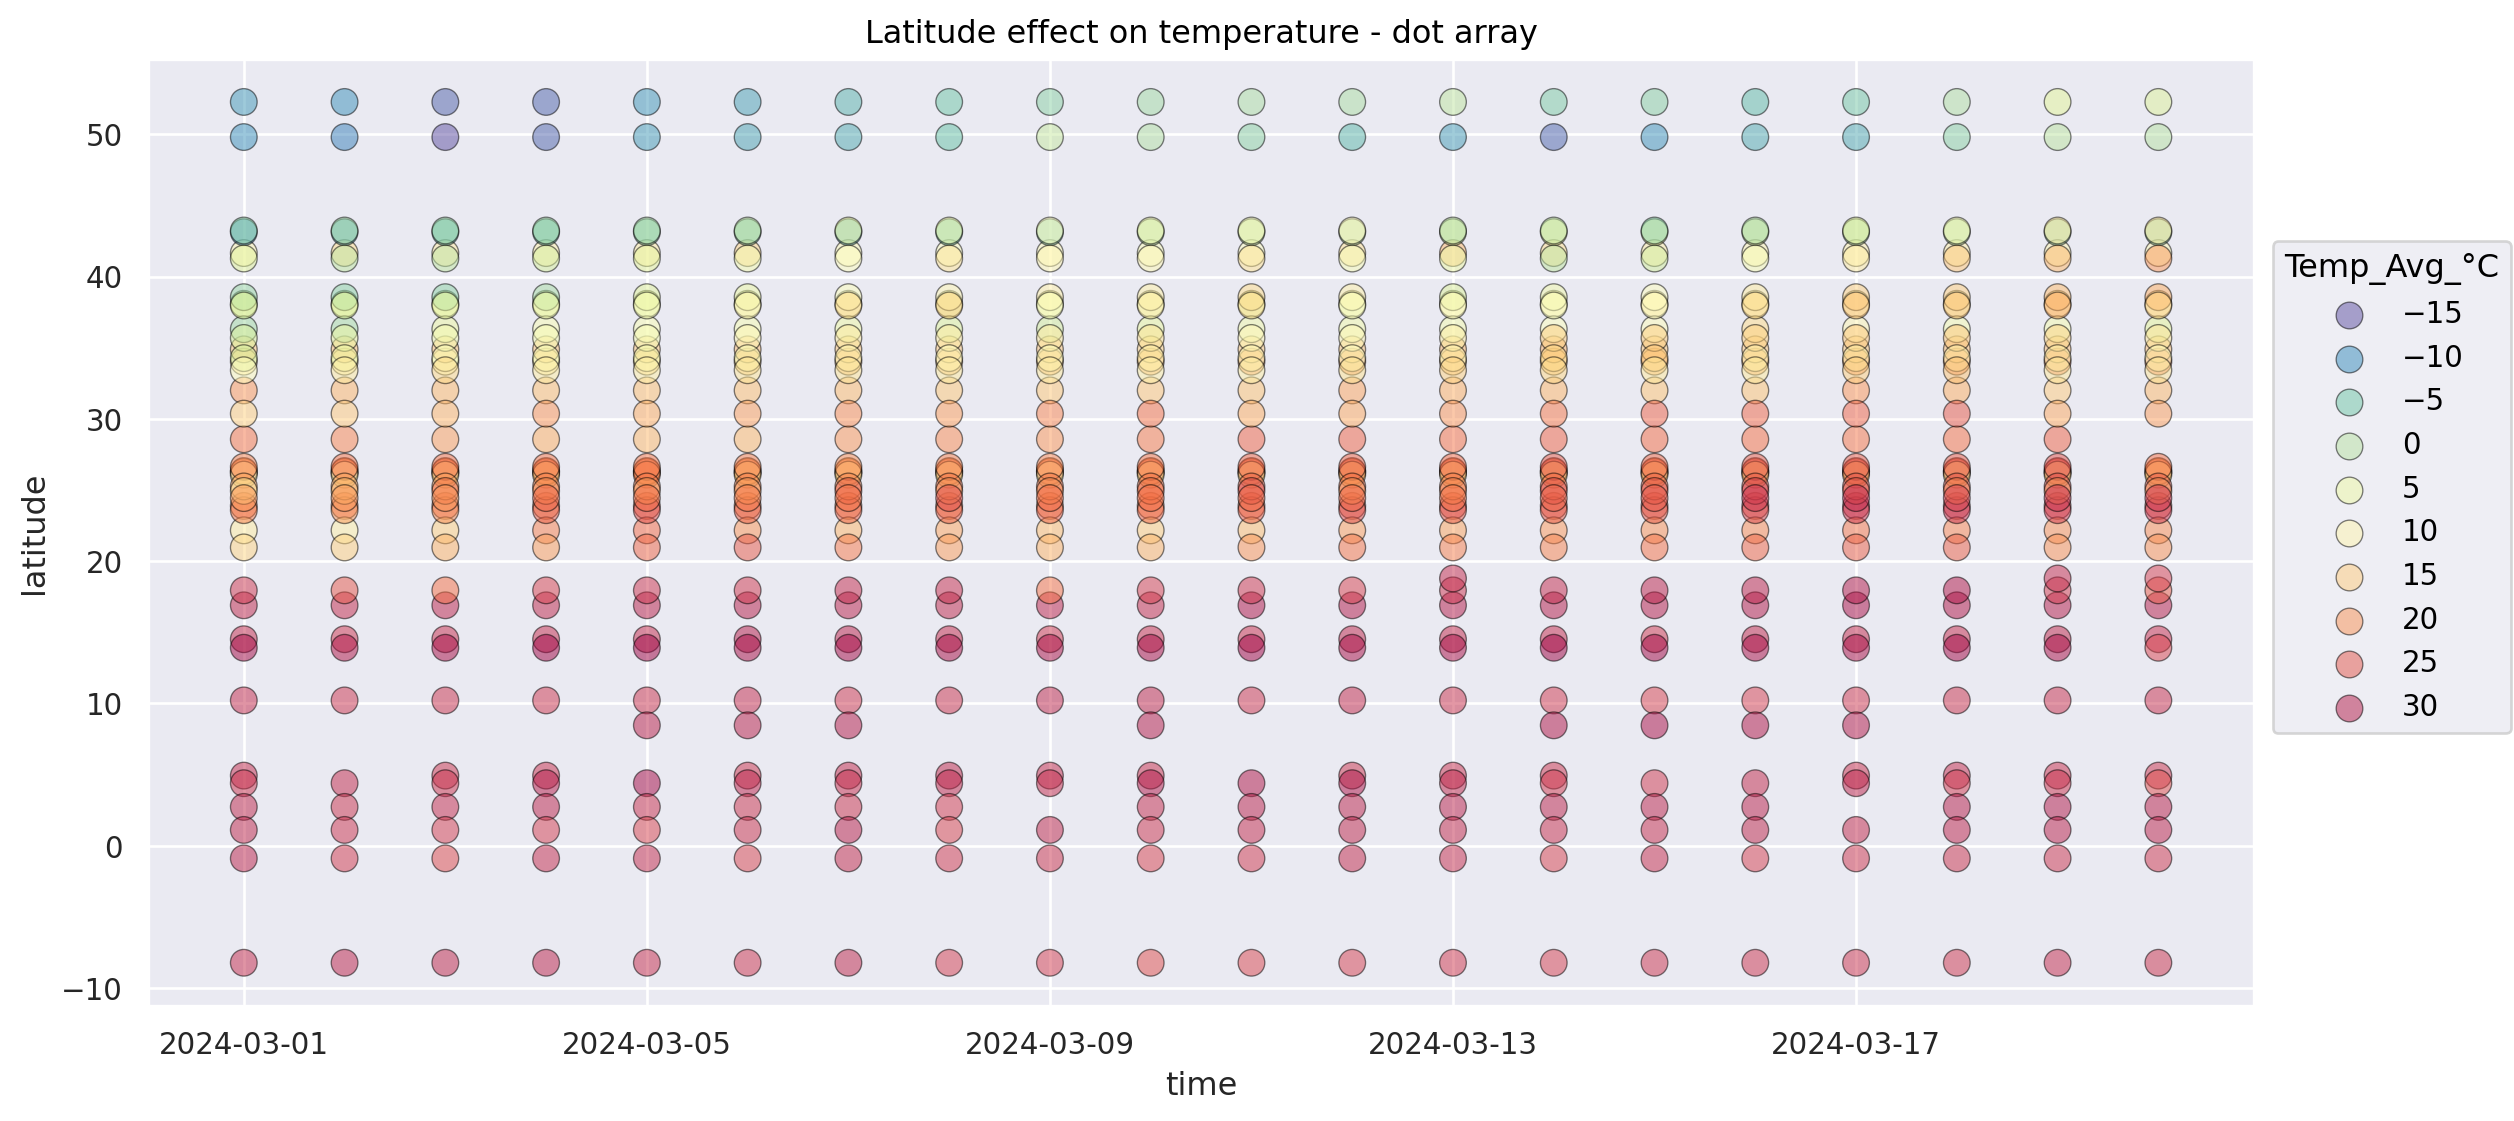

In [13]:
(
	so.Plot(weather_df.loc[weather_df["Continent"] == "Asia"], x="time", y="latitude", color="Temp_Avg_°C")
    #!# .add(so.??(alpha=0.5, pointsize=10, edgecolor="black"))
    .add(so.Dot(alpha=0.5, pointsize=10, edgecolor="black"))
	.scale(
	#!# color = so.Continuous(??).tick(upto=10) # Important: choosing an intuitive colormap (https://seaborn.pydata.org/tutorial/color_palettes.html)
        color = so.Continuous("Spectral_r").tick(upto=10) # Important: choosing an intuitive colormap (https://seaborn.pydata.org/tutorial/color_palettes.html)
        ) 
    .layout(size=(12, 6))
    .label(title="Latitude effect on temperature - dot array")
)

### Alternative: Heatmap-like (via Dash)

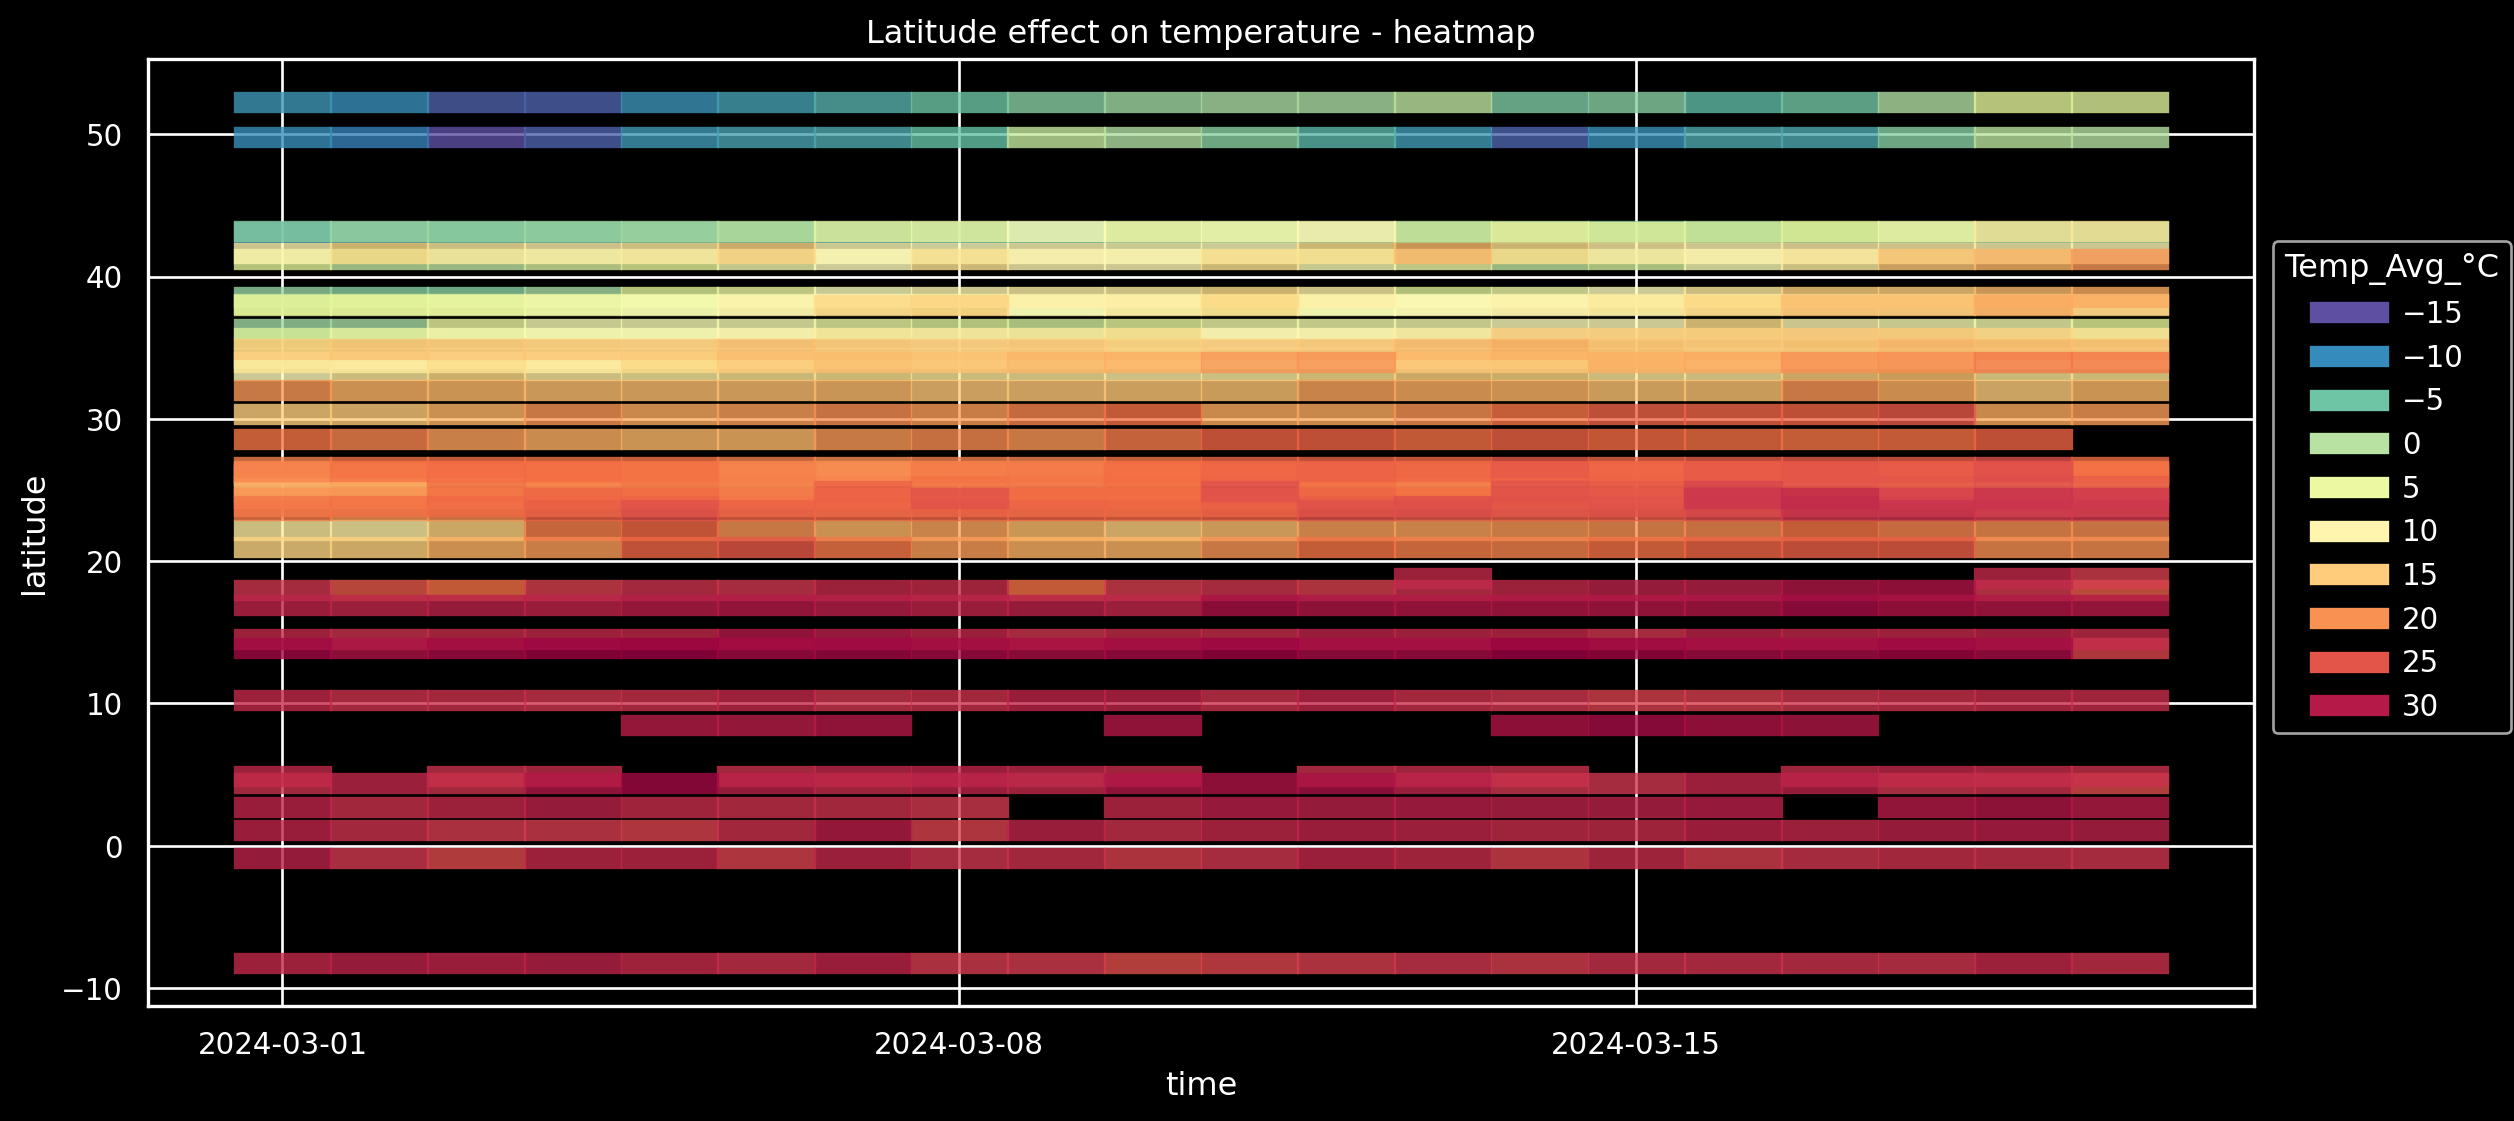

In [14]:
(
    so.Plot(weather_df.loc[weather_df["Continent"] == "Asia"], x="time", y="latitude", color="Temp_Avg_°C")
	#!# .add(so.??(alpha=0.8, width=0.8,  linewidth=8))
	.add(so.Dash(alpha=0.8, width=0.8,  linewidth=8))
	.scale(
        color=so.Continuous("Spectral_r").tick(upto=10)
        )
    .layout(size=(12, 6))
#!#	.theme({**style.library[??]}) # Increasing visibility on screens?
    .theme({**style.library["dark_background"]}) # Increasing visibility on screens?
    .label(title="Latitude effect on temperature - heatmap")
)

### On all continents? no problem: facet

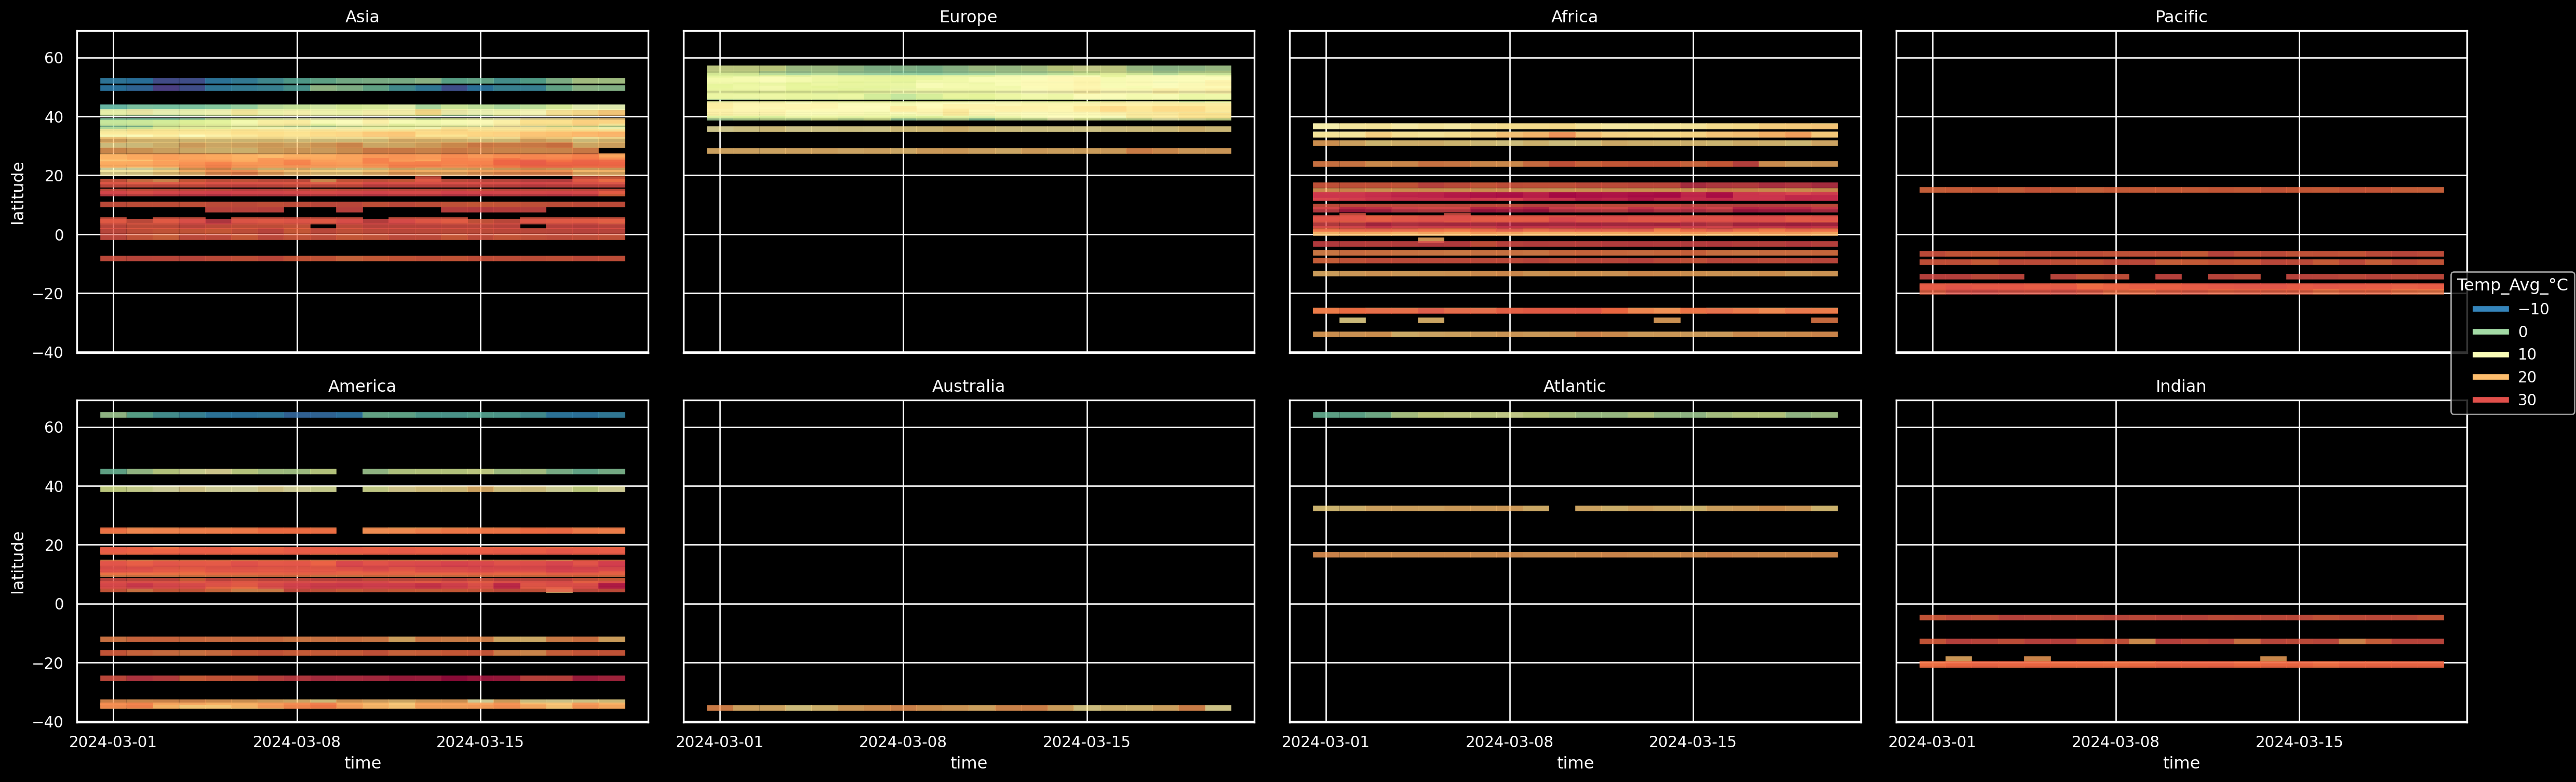

In [43]:
(
    so.Plot(weather_df, x="time", y="latitude", color="Temp_Avg_°C")
    .add(so.Dash(alpha=0.8, width=0.8,  linewidth=4))
	.scale(
        color=so.Continuous("Spectral_r").tick(upto=10)
        )
	#!# .facet(??, wrap=4).layout(size=(25, 8))
	.facet("Continent", wrap=4).layout(size=(25, 8))
	.theme({**style.library["dark_background"]}) 
)

## Example: what to do if you want to plot 3-4 variables?
### interactive 3D plot with plotly

In [18]:

fig = px.scatter_3d(weather_df, x="Dew_point_°C", y="latitude", z="Temp_Avg_°C",
                    #!# color=??, ##  for fourth dimension
                    color="Rel_Humidity_%", ##  for fourth dimension
					opacity=0.7) 
fig.update_traces(marker_size = 2)  # Make dots smaller
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) # Reduce figure margins
fig.show()